# **Analyzing Battle Data from Matches in the Mobile Game Clash Royale**

### **Can we develop a winning deck using card and match data from the Clash Royale API?**
 ___
Kyle Hodowany, Kendrick Neptune, Jason Shim, Pranay Srivastava\
Data Science for Engineers (ME 379M)\
Instructor: Dr. Ilyas Iyoob\
April 18, 2023

In [73]:
from IPython.display import Image
Image(url='https://clashroyale.com/uploaded-images-blog/CR_facebook_share_02_180403_175322.jpg?mtime=20180403175322')

In [74]:
Image(url='https://img.utdstc.com/screen/269/d4c/269d4cac621024dfa133c0983c8956104608b0403e2d57d03ce06ee509c5eb27:600')

## **Initializing and Importing Data**


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import pandas as pd
import numpy as np
import os
import ast
from scipy import stats
import pandas as pd

from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

### Battle Data

In [77]:
sample_battle_data_df = pd.read_csv("/content/drive/MyDrive/ME 379M/Hackathon 2023/battle_data_df.csv")
sample_battle_data_df = sample_battle_data_df.drop(columns='Unnamed: 0')
sample_battle_data_df.head()

,type,gameMode,crowns1,startingTrophies2,crowns2,deck1,deck2,avg_cards_level_1,avg_cards_level_2,avg_cards_level_diff,avg_cost_1,avg_cost_2,avg_cost_diff,crowns_won,winner
0,pathOfLegend,"{'id': 72000328, 'name': 'Ranked1v1_CrownRush'}",0,1656.0,1,"['Mirror', 'Inferno Dragon', 'Arrows', 'Guards...","['Zap', 'Ice Golem', 'Three Musketeers', 'Mine...",14.000,14.00,0.000,3.750,4.125,0.375,1,2
1,PvP,"{'id': 72000201, 'name': 'Ladder_CrownRush'}",1,6849.0,3,"['Ram Rider', 'Goblin Barrel', 'Dark Prince', ...","['Minion Horde', 'Golden Knight', 'Elixir Gole...",14.000,14.00,0.000,3.625,3.750,0.125,2,2
2,PvP,"{'id': 72000006, 'name': 'Ladder'}",1,6756.0,0,"['Archers', 'Bomb Tower', 'Goblins', 'Mighty M...","['The Log', 'Wizard', 'Arrows', 'Rage', 'Bombe...",14.000,14.00,0.000,3.000,3.625,0.625,-1,1
3,PvP,"{'id': 72000006, 'name': 'Ladder'}",3,5530.0,0,"['Bandit', 'Valkyrie', 'Elite Barbarians', 'Mu...","['Sparky', 'Firecracker', 'Zap', 'Tombstone', ...",13.125,11.25,-1.875,3.875,3.875,0.000,-3,1
4,pathOfLegend,"{'id': 72000323, 'name': 'Ranked1v1'}",0,1539.0,1,"['Miner', 'Archers', 'Mini P.E.K.K.A', 'Fireba...","['Electro Giant', 'Fire Spirit', 'Tornado', 'P...",14.000,14.00,0.000,3.750,3.750,0.000,1,2


In [78]:
# Converting decks from strings to list
def csv_list(string):
    output_list = string.replace('[','').replace(']','').replace('\'','').split(',')
    output_list = list(map(lambda x: x.strip(), output_list))
    return output_list

sample_battle_data_df['deck1'] = sample_battle_data_df['deck1'].apply(csv_list)
sample_battle_data_df['deck2'] = sample_battle_data_df['deck2'].apply(csv_list)

### Card Data

In [79]:
card_stats_df = pd.read_csv('/content/drive/MyDrive/ME 379M/Hackathon 2023/Card Stats/card_info.csv')
card_stats_df = card_stats_df.sort_values(by='name').reset_index(drop=True)

### Use and Win Rates

In [80]:
# Importing card data to add elixir costs
card_rates_df = pd.read_csv('/content/drive/MyDrive/ME 379M/Hackathon 2023/Card Stats/card_rates.csv')
card_rates_df = card_rates_df.rename(columns={'Unnamed: 0': 'Name'})
card_rates_df = card_rates_df.sort_values(by='Name').reset_index(drop=True)

In [81]:
# Add Use and Win Rates to card stats table
card_stats_df['use_rate'] = card_rates_df['Use_Rate']
card_stats_df['win_rate'] = card_rates_df['Win_Rate']
card_stats_df.head()

,name,cost,category,type,hitpoints,damage,dps,count,total_hitpoints,total_damage,total_dps,use_rate,win_rate
0,Archer Queen,5,Ranged,Support,1330.0,299,249.0,1,1330,299,249.0,0.007,0.447
1,Archers,3,Ranged,Support,403.0,142,157.0,2,806,284,314.0,0.104,0.451
2,Arrows,3,Utility,Spell,0.0,486,0.0,1,0,486,0.0,0.266,0.472
3,Baby Dragon,4,Ranged,Support,1526.0,212,141.0,1,1526,212,141.0,0.155,0.473
4,Balloon,5,Attacker,Win Con,2226.0,848,424.0,1,2226,848,424.0,0.102,0.474


## **Insights**

### Trophy Levels

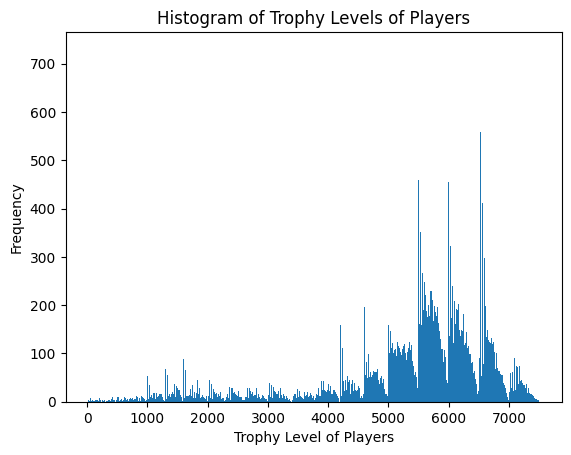

In [82]:
# Create a histogram with 1000 bins
plt.hist(sample_battle_data_df['startingTrophies2'],bins = 1000)

# Add x and y labels and a title
plt.xlabel('Trophy Level of Players')
plt.ylabel('Frequency')
plt.title('Histogram of Trophy Levels of Players')

# Display the histogram
plt.show()

### Plot of Average Deck Level Versus Trophy Ranking

In [83]:
# Create a new variable for the match that computes the average deck level 
sample_battle_data_df['avg_deck_level'] = (sample_battle_data_df['avg_cards_level_1'] + sample_battle_data_df['avg_cards_level_2'])/2

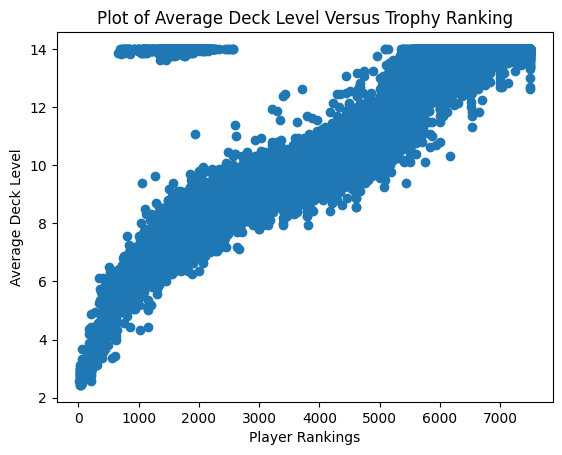

In [84]:
# plot the data
plt.plot(sample_battle_data_df['startingTrophies2'], sample_battle_data_df['avg_deck_level'], linestyle='none', marker = 'o')

# set the axis labels and title
plt.xlabel('Player Rankings')
plt.ylabel('Average Deck Level')
plt.title('Plot of Average Deck Level Versus Trophy Ranking')

# display the plot
plt.show()

### Plot of Use Rate vs Win Rate of a Card

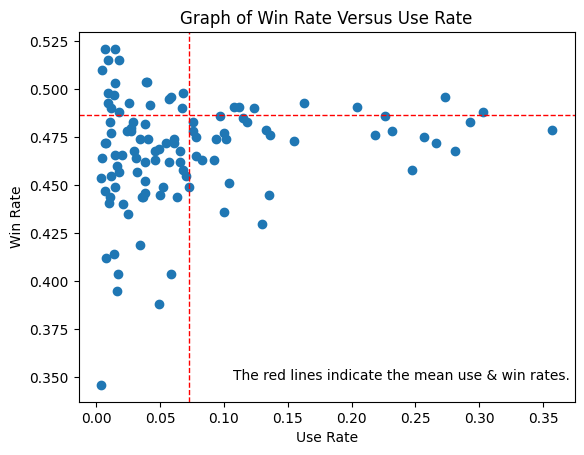

In [85]:
# plot the data
plt.plot(card_stats_df['use_rate'], card_stats_df['win_rate'], linestyle='none', marker = 'o')

# set the axis labels and title
plt.xlabel('Use Rate')
plt.ylabel('Win Rate')
plt.title('Graph of Win Rate Versus Use Rate')

# Annotation
plt.axvline(0.072745, color='r', linestyle = '--', linewidth = 1)
plt.axhline(0.486645, color='r', linestyle = '--', linewidth = 1)

# add annotation to the plot
plt.annotate('The red lines indicate the mean use & win rates.', 
             xy=(0.99, 0.05), 
             xycoords='axes fraction',
             fontsize=10,
             horizontalalignment='right',
             verticalalignment='bottom')

# display the plot
plt.show()

## **Develop Deck**

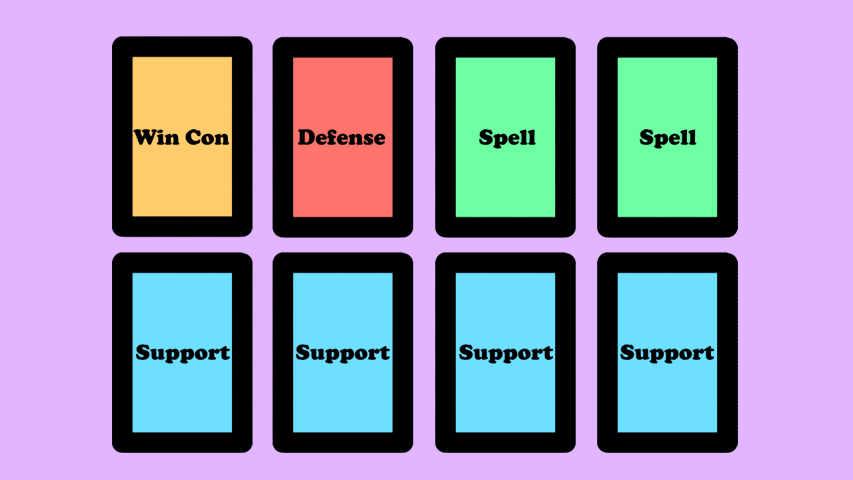

### Deck-Building using Win Rates & Synergy

In [97]:
card_stats_df['win_use_ratio'] = card_stats_df['win_rate'] * card_stats_df['use_rate']

# Filter for the different types of cards
building_filter = card_stats_df['type'] == 'Building'
spell_filter = card_stats_df['type'] == 'Spell'
wincon_filter = card_stats_df['type'] == 'Win Con'

# Select the top card for each type
top_building = card_stats_df.loc[building_filter].nlargest(1, 'win_use_ratio')['name'].tolist()
top_spells = card_stats_df.loc[spell_filter].nlargest(2, 'win_use_ratio')['name'].tolist()
top_wincon = card_stats_df.loc[wincon_filter].nlargest(1, 'win_use_ratio')['name'].tolist()

# Combine the top cards into a single list
custom_deck = []
custom_deck.extend(top_wincon + top_building + top_spells)

print(custom_deck)

['Hog Rider', 'Inferno Tower', 'The Log', 'Arrows']


### Sample Synergy Table
Card - Golem <br>
<br>
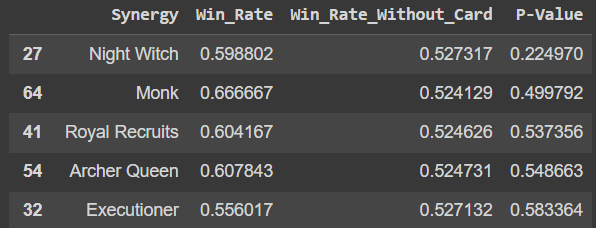

In [98]:
synergy_path = '/content/drive/MyDrive/ME 379M/Hackathon 2023/Synergy Tables'
custom_deck_part_2 = []
for card_name in custom_deck:
    file_path = os.path.join(synergy_path, f"{card_name}.csv")
    card_synergy_df = pd.read_csv(file_path)
    
    # Remove already existing cards in the deck from options to add
    card_synergy_df = card_synergy_df[~card_synergy_df['Synergy'].isin(custom_deck)]
    card_synergy_df = card_synergy_df[~card_synergy_df['Synergy'].isin(custom_deck_part_2)]
    card_synergy_df = card_synergy_df.reset_index(drop=True)
    for i in range(len(card_synergy_df['Synergy'])):
        name_filter = card_stats_df['name'] == card_synergy_df['Synergy'][i]
        if card_stats_df.loc[name_filter, 'type'].item() == 'Support':
            custom_deck_part_2.append(card_synergy_df['Synergy'][i])
            break
print(custom_deck_part_2)

['Goblin Gang', 'Knight', 'Princess', 'Royal Ghost']


In [99]:
custom_deck += custom_deck_part_2
print('Fully Developed Deck:', custom_deck)

Fully Developed Deck: ['Hog Rider', 'Inferno Tower', 'The Log', 'Arrows', 'Goblin Gang', 'Knight', 'Princess', 'Royal Ghost']


### Validating using Random Forest Classifier Simulation
* We loop through matchups in our random forest model and see how many wins are predicted.

In [89]:
sample_df = pd.read_csv('/content/drive/MyDrive/ME 379M/Hackathon 2023/sample_df.csv')

X = sample_df.drop(['Unnamed: 0', 'deck', 'winner', 'avg_deck_level', 'avg_cards_level', 'startingTrophies2'],axis=1)
y = sample_df[['winner']].values

cols = X.columns.tolist()

X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

sample_df.head()

,Unnamed: 0,startingTrophies2,winner,avg_deck_level,deck,crowns,avg_cards_level,opp_cards_level,avg_cost,opp_cost,...,Three Musketeers,Tombstone,Tornado,Valkyrie,Wall Breakers,Witch,Wizard,X-Bow,Zap,Zappies
0,2,6760,1,14.0000,"['Archers', 'Bomb Tower', 'Goblins', 'Mighty M...",1,14.000,14.00,3.000,3.625,...,0,0,0,0,1,0,0,0,0,0
1,2,6760,1,14.0000,"['Archers', 'Bomb Tower', 'Goblins', 'Mighty M...",1,14.000,14.00,3.000,3.625,...,0,0,0,0,0,0,1,0,0,0
2,2,6760,0,14.0000,"['The Log', 'Wizard', 'Arrows', 'Rage', 'Bombe...",0,14.000,14.00,3.625,3.000,...,0,0,0,0,1,0,0,0,0,0
3,2,6760,0,14.0000,"['The Log', 'Wizard', 'Arrows', 'Rage', 'Bombe...",0,14.000,14.00,3.625,3.000,...,0,0,0,0,0,0,1,0,0,0
4,3,5530,1,12.1875,"['Bandit', 'Valkyrie', 'Elite Barbarians', 'Mu...",3,13.125,11.25,3.875,3.875,...,0,0,0,1,0,0,0,0,0,0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  15.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


[CV] END .................................................... total time=  15.8s
=== Confusion Matrix ===


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s finished


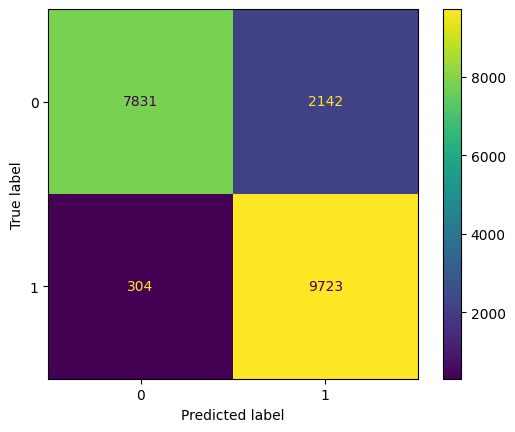


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      9973
           1       0.82      0.97      0.89     10027

    accuracy                           0.88     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.88      0.88     20000


=== AUC Scores ===
[0.94112315 0.94135966]

=== Mean AUC Score ===
0.9412414035999999


In [90]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

# for the purposes of demo, running only few cross-validation folds
rfc_cv_score = cross_val_score(rfc, X, y, cv=2, scoring='roc_auc', verbose=2)

print("=== Confusion Matrix ===")
mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
mat.plot()
plt.show()
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== AUC Scores ===")
print(rfc_cv_score)
print("\n=== Mean AUC Score ===")
print(rfc_cv_score.mean())

## **Validation and Sensibility**

### Simulation Validation

In [91]:
val_csv = pd.read_csv('/content/drive/MyDrive/ME 379M/Hackathon 2023/Testing Only/battle_data_val_sim.csv')
X_val = val_csv.drop(['Unnamed: 0', 'winner', 'avg_deck_level', 'avg_cards_level', 'startingTrophies2', 'avg_elixir_cost'],axis=1).values
y = val_csv[['winner']].values



=== Confusion Matrix ===


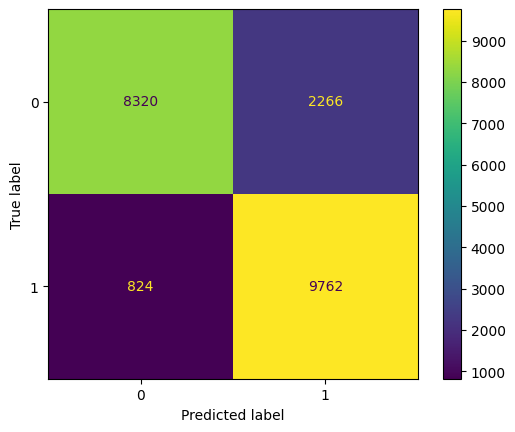



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.79      0.84     10586
           1       0.81      0.92      0.86     10586

    accuracy                           0.85     21172
   macro avg       0.86      0.85      0.85     21172
weighted avg       0.86      0.85      0.85     21172





In [92]:
y_pred = rfc.predict(X_val)

print('\n')
print("=== Confusion Matrix ===")
mat = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
mat.plot()
plt.show()
print('\n')
print("=== Classification Report ===")
print(classification_report(y, y_pred))
print('\n')

### Test Custom Deck

In [93]:
def how_many_A_in_B(list1,list2):
    set2 = set(list2)
    return sum(1 for item in list1 if item in set2)

In [94]:
# define function to compute the elixir costs for a deck
def compute_elixir_costs(deck):
    card_costs = dict(zip(card_stats_df['name'], card_stats_df['cost']))
    elixir_costs = [card_costs.get(card, None) for card in deck if card not in [None, 'None']]
    return elixir_costs

input_df = pd.DataFrame.from_dict({'deck': [custom_deck]})

# find average cost of deck 
input_df['cost'] = (input_df['deck'].apply(compute_elixir_costs))
input_df['avg_cost'] = [sum(x)/8 for x in input_df['cost']]
input_df.drop(['cost'], axis=1, inplace=True)

# incorporating card specs and frequencies
stats_df = card_stats_df.copy().drop(['use_rate', 'win_rate', 'win_use_ratio'], axis=1)

for spec in stats_df.drop(['type', 'category', 'cost'], axis=1).columns[1:]:
    input_df[spec] = input_df['deck'].apply(lambda x: sum(stats_df.loc[stats_df['name'].isin(x), spec]))

troops_list = stats_df['name'].to_list() 
input_df['Troop_num'] = input_df['deck'].apply(lambda x: how_many_A_in_B(x,troops_list))
for card_type in list(card_stats_df['category'].unique()):
    input_df[card_type] = input_df['deck'].apply(lambda x: how_many_A_in_B(x,list(card_stats_df['name'].loc[card_stats_df['category']==card_type])))

all_names = card_stats_df['name']
all_names = [i for i in all_names if i is not None]
name_df = pd.DataFrame(columns=all_names)
name_df = pd.DataFrame(input_df['deck'].apply(lambda x: [1 if name in x else 0 for name in all_names]).tolist(), columns=all_names, index=input_df.index).astype(int)

input_df = input_df.join(name_df)
input_df.drop('deck',axis=1,inplace=True)

input_df.head()

,avg_cost,hitpoints,damage,dps,count,total_hitpoints,total_damage,total_dps,Troop_num,Ranged,...,Three Musketeers,Tombstone,Tornado,Valkyrie,Wall Breakers,Witch,Wizard,X-Bow,Zap,Zappies
0,3.25,9293.0,2604,1482.0,10,10179,3138,1896.0,8,1,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# number of opponents
opps = 250

odds = np.arange(0,3.5,0.5)
opps_level = np.arange(11,17.1,0.1)
opps_cost = np.arange(2.5,5.0,0.1)

for odd in odds:
    pred = []
    for opp in range(opps):
        i_level = np.random.randint(0,len(opps_level)-1)
        i_cost = np.random.randint(0,len(opps_cost)-1)
        new_df = pd.DataFrame.from_dict({'crowns': [odd]})
        input_df_val = input_df.join(new_df)
        input_df_val['opp_cards_level'] = float(opps_level[i_level])
        input_df_val['opp_cost'] = float(opps_cost[i_cost]) 
        input_val = input_df_val[cols]
        pred_val = rfc.predict(input_val)
        pred.append(pred_val)
        
    print('Crown Odds: {} \t Success: {}'.format(odd, np.mean(pred)))

Crown Odds: 0.0 	 Success: 0.0
Crown Odds: 0.5 	 Success: 0.0
Crown Odds: 1.0 	 Success: 1.0
Crown Odds: 1.5 	 Success: 1.0
Crown Odds: 2.0 	 Success: 1.0
Crown Odds: 2.5 	 Success: 1.0
Crown Odds: 3.0 	 Success: 1.0
